In [2]:
#Will Matava, Kyle Klein

#Takes in Coincidence Data for MiniPET with 2 PCBs connected; outputs 2 plots showing charge spectra for each channel

#NOTE ALL RUNS TAKEN BEFORE 4-20 HAVE LEFT AND RIGHT SWAPPED

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import seaborn as sns
from tqdm import tqdm
import statistics as stat

pd.set_option("display.max_columns",100)

def generateTextY(num,max):
    y = [max - 0.04*(i+1)*max for i in range(0,num+1)]
    return y

def gauss(x,A,mu,sigma):
    y = A*np.exp(-(x - mu)**2 / (2 * sigma**2))
    return y


dir = "../Run30-32OV/"
run_num = 54
pltdir = "../Run30-32OV/Run" + str(run_num) + "/"

indices = {
      0 : (4,7-7),
      1 : (4,7-6),
      2 : (7,7-5),
      3 : (5,7-7),
      4 : (5,7-4),
      5 : (5,7-5),
      6 : (4,7-4),
      7 : (7,7-7),
      8 : (6,7-6),
      9 : (7,7-4),
      10 : (5,7-6),
      11 : (6,7-4),
      12 : (4,7-5),
      13 : (6,7-5),
      14 : (6,7-7),
      15 : (7,7-6),
      16 : (3,7-7),
      17 : (3,7-6),
      18 : (2,7-7),
      19 : (2,7-6),
      20 : (0,7-7),
      21 : (1,7-7),
      22 : (0,7-6),
      23 : (1,7-6),
      24 : (3,7-5),
      25 : (1,7-5),
      26 : (2,7-5),
      27 : (4,7-3),
      28 : (0,7-5),
      29 : (3,7-4),
      30 : (0,7-4),
      31 : (1,7-4),
      32 : (2,7-4),
      33 : (3,7-3),
      34 : (2,7-3),
      35 : (0,7-3),
      36 : (1,7-3),
      37 : (0,7-2),
      38 : (5,7-3),
      39 : (1,7-2),
      40 : (2,7-2),
      41 : (3,7-2),
      42 : (1,7-1),
      43 : (0,7-1),
      44 : (0,7-0),
      45 : (3,7-1),
      46 : (1,7-0),
      47 : (2,7-1),
      48 : (3,7-0),
      49 : (2,7-0),
      50 : (6,7-2),
      51 : (6,7-1),
      52 : (7,7-1),
      53 : (4,7-1),
      54 : (5,7-1),
      55 : (6,7-0),
      56 : (7,7-0),
      57 : (7,7-2),
      58 : (7,7-3),
      59 : (4,7-2),
      60 : (5,7-0),
      61 : (5,7-2),
      62 : (6,7-3),
      63 : (4,7-0),
      64:(3+8,7),
      65:(3+8,6),
      66:(2+8,4),
      67:(2+8,6),
      68:(3+8,4),
      69:(1+8,7),
      70:(1+8,5),
      71:(0+8,7),
      72:(1+8,6),
      73:(3+8,3),
      74:(2+8,7),
      75:(2+8,3),
      76:(3+8,5),
      77:(0+8,5),
      78:(2+8,5),
      79:(0+8,6),
      80:(4+8,7),
      81:(6+8,7),
      82:(5+8,7),
      83:(7+8,7),
      84:(5+8,6),
      85:(4+8,6),
      86:(6+8,6),
      87:(7+8,6),
      88:(4+8,5),
      89:(6+8,5),
      90:(5+8,5),
      91:(1+8,4),
      92:(7+8,5),
      93:(7+8,4),
      94:(6+8,4),
      95:(4+8,4),
      96:(5+8,4),
      97:(5+8,3),
      98:(6+8,3),
      99:(4+8,3),
      100:(7+8,3),
      101:(7+8,2),
      102:(0+8,4),
      103:(6+8,2),
      104:(7+8,1),
      105:(5+8,2),
      106:(6+8,1),
      107:(4+8,2),
      108:(7+8,0),
      109:(5+8,1),
      110:(6+8,0),
      111:(4+8,1),
      112:(5+8,0),
      113:(4+8,0),
      114:(0+8,2),
      115:(2+8,1),
      116:(0+8,1),
      117:(3+8,1),
      118:(1+8,1),
      119:(1+8,0),
      120:(0+8,0),
      121:(1+8,2),
      122:(1+8,3),
      123:(3+8,2),
      124:(2+8,0),
      125:(2+8,2),
      126:(0+8,3),
      127:(3+8,0)}

#converts PETSys ID to geometric ID
def toGeo(x):
    y = 8*indices.get(x)[0] + indices.get(x)[1]
    return y


In [3]:
df = pd.read_csv(dir+"Run{}_DATA.csv".format(run_num), sep=",", low_memory=False)
#only keeping the data that passed the cuts
data = df[df["E_Cut"] == 1].reset_index(drop=True)
data = data[data["PP_Cut"] == 1].reset_index(drop=True)

a = [toGeo(i) for i in data["ChannelIDL"]]
b = [toGeo(i) for i in data["ChannelIDR"]]

data["GeoChannelIDL"] = a
data["GeoChannelIDR"] = b
data["CTR"] = np.abs(data["CTR"])

a1 = [toGeo(i) for i in df["ChannelIDL"]]
b1 = [toGeo(i) for i in df["ChannelIDR"]]

df["GeoChannelIDL"] = a1
df["GeoChannelIDR"] = b1
df["CTR"] = np.abs(df["CTR"])

In [705]:
import math
class Fit:
    # default parameters
    binwidth_E = 0.5
    binwidth_T = 0.01
    limit = np.array([[0,15],[0,0.4],[0,1]])
    WTH_D = 1 # default peak-finding width
    LIN_P = [0,0.0001]
    LIN_BOUNDS = ([-np.inf,-np.inf],[np.inf,np.inf])
    STDY = 2
    MINLENGTH = 4
    
    @staticmethod
    def bins(x,binwidth):
        rangex = max(x)-min(x)
        if(rangex<binwidth):
            return 1
        return int(rangex/binwidth)
            
    
    @staticmethod
    def limitSize(limits,length):
        if(limits[0] < 0):
            limits[0]=0
        if(limits[1]>length):
            limits[1]=length
        return limits
    
    @staticmethod
    def limitRange(limits,values):
        for i in range(len(values)):
            if((limits[0][i]>values[i]) or (limits[1][i]<values[i])):
                return False
        return True
    
    @staticmethod
    def weight_stat(values, weights):
        """
        Return the weighted average and standard deviation.
        values, weights -- Numpy ndarrays with the same shape.
        """
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
        variance = variance*(np.sum(weights)/(np.sum(weights)-1)) # Bessel's correction (unbiased variance)
        return (average, math.sqrt(variance)) # note that this is still biased standard deviation.
    
    @staticmethod
    def RSQ(obs,exp):
        sig = stat.stdev(exp)**2
        return (np.sum((obs-exp)**2)/sig)

    @staticmethod
    def line(x, *param):
        p = [1,0] # slope, intercept
        p[0:len(param)] = param
        return np.array(x*p[0]+p[1])
    
    @staticmethod
    def gaussian(x, *param):
        p = [1,0,1] # amplitude, mean, standard deviation
        p[0:len(param)] = param
        return p[0]*np.exp(-(x-p[1])**2/(2.*p[2]**2))
    
    @staticmethod
    def linearFit(x,y,**kwargs):
        try:
            lin_bounds=kwargs.get('LIN_BOUNDS',Fit.LIN_BOUNDS)
            n=len(x)
            slope = (np.dot(x,y)-(1/n)*(np.sum(x)*np.sum(y)))/(np.dot(x,x) - (1/n)*math.pow(np.sum(x),2))
            intercept = (np.sum(y)*np.dot(x,x) - np.sum(x)*np.dot(x,y))/(np.dot(x,x)-math.pow(np.sum(x),2))       
            p0 = [slope,intercept]
            if not Fit.limitRange(lin_bounds,p0):
                p0 = Fit.LIN_P
            p, cov = curve_fit(Fit.line,x,y,p0=p0,bounds=LIN_BOUNDS)
        except:
            print("FIT Failed")
            return np.array(p0)
            print(p0)
        else:
            return np.array(p)
     
    @staticmethod
    def __peakFilter(x,y,peaks,**kwargs):
        # default
        WTH=kwargs.get('WTH',Fit.WTH_D) # width multiplier for peak finding (note that default is global call)
        WTH=kwargs.get('width',WTH) # now a local call
        
        _peaks = []
        for peak in peaks:
            d = peak[1]-peak[0]
            sig = (WTH-1)/2
            st = int(peak[0]-sig*d)
            if(st<0):
                st = 0
            ed = int(peak[1]+sig*d)
            if(ed>=len(x)):
                ed = len(x)-1
            _peaks.append([st,ed])
            
        _peaks = np.array(_peaks) 
        
        clean=np.zeros(len(x))
        signal=np.zeros(len(x))
        for peak in _peaks:
            signal[peak[0]:peak[1]] = y[peak[0]:peak[1]]
        clean = y-signal
            
        return clean,signal,_peaks
    
    @staticmethod
    def peaks(x,y,**kwargs):
        # default
        STDY=kwargs.get('STDY',Fit.STDY) # standard deviation cut for peak finding
        MINLENGTH=kwargs.get('MINLENGTH',Fit.MINLENGTH)
            
        σ = stat.stdev(y)
        TRHLD = STDY*σ
        _clean = np.zeros(len(x))
        for f in range(0,len(x)):
            if((y[f]<TRHLD) and (y[f]>-TRHLD)):
                _clean[f]=y[f]
        _peak_data = [] # [[init, final x],[//,//]..]
        
        st = 0;
        collect = False
        for f in range(0,len(x)-1):
            if(_clean[f]==0 and _clean[f+1]!=0):
                _peak_data.append([st,f])
                collect = True
            if(_clean[f]!=0 and _clean[f+1]==0):
                st = f
        j=0
        for i in range(0,len(_peak_data)):
            length = (_peak_data[j][1] - _peak_data[j][0])
            if(length<=MINLENGTH):
                _peak_data.pop(j)
                j-=1
            j+=1
        _clean = np.array(_clean)
        _signal = np.array(y - _clean)
        clean, signal, _peak_data = Fit.__peakFilter(x,y,_peak_data,**kwargs)
        return  clean, signal, _peak_data # background, signal, signal in array format
    @staticmethod
    def getPeak(x,y,peak):
        return x[peak[0]:peak[1]],y[peak[0]:peak[1]]
    
    @staticmethod
    def lastPeak(x,y,_peak_data):
        return Fit.getPeak(x,y,_peak_data[len(_peak_data)-1]) 
    
    @staticmethod
    def gaussianFit(x_peak,y_peak,x,y,**kwargs):
        # default
        STDFIT=kwargs.get('STDFIT',3) # standard deviation range for peak finding
                
        try:
            mean,std = Fit.weight_stat(x_peak,y_peak)
            if (mean is np.nan or std is np.nan):
                mean = np.median(x)
                std = 1
            p0 = np.array([np.max(y),mean,std])
            p, cov = curve_fit(Fit.gaussian,x_peak,y_peak,p0=p0,maxfev=100000)
        except:
            print(p0)
            print("FIT Failed")
        else:
            try:
                rf = Fit.limitSize([int(p[1]-STDFIT*p[2]),int(p[1]+STDFIT*p[2])],len(x))
                
                xs = x[rf[0]:rf[1]]
                ys = y[rf[0]:rf[1]]
                p2, cov = curve_fit(Fit.gaussian,x,y,p0=p)
            except:
                print("FIT2 Failed")
                return p
            else:
                return p2
    @staticmethod
    def removeBKG(x,y,bkg,**kwargs):
        try:
            indx = np.array([i for i in range(0,len(x)) if bkg[i]!=0]).astype(int)
            xs=x[indx]
            bs=bkg[indx]
            p = Fit.linearFit(xs,bs,**kwargs)
            rsq = Fit.RSQ(y,Fit.line(x,p[0],p[1]))
            ys = y - Fit.line(x,p[0],p[1])
        except E:
            print("Background Removal Failed")
            return y, None, None
        else:
            return ys, p, rsq
    # fit all gaussians in data with linear background (last fit is background)
    @staticmethod
    def lazyPeaks(x,y,**kwargs):
        # default
        MAXITER=kwargs.get('MAXITER',10) # number of width iterations for peak/background seperation
        RSQLIMIT=kwargs.get('RSQLIMIT',9000) # if RSQ is lower than this limit, then we have succeeded
        
        width=kwargs.get('WTH',Fit.WTH_D)

        for i in tqdm(range(MAXITER)):
            clean,signal,peak_data = Fit.peaks(x,y,width=width,**kwargs)
            ys, p, rsq = Fit.removeBKG(x,y,clean,**kwargs)
            if rsq < RSQLIMIT:
                break
            else:
                width=width*1.5
                    
        return clean,signal,peak_data,ys,p
    @staticmethod
    def lazyGaussianFit(x,y,**kwargs):
        USEBKG=kwargs.get('USEBKG',False)
        if USEBKG:
            clean,signal,peak_data,ys,p = Fit.lazyPeaks(x,y,**kwargs)
        else:
            clean,signal,peak_data = Fit.peaks(x,y,**kwargs)
            ys=y
            p=None
        fits=[]
        for peak in peak_data:
            xsz,ysz=Fit.getPeak(x,ys,peak)
            fits.append(Fit.gaussianFit(xsz,ysz,x,ys,**kwargs))
        return fits,p   
    @staticmethod
    def lastGaussianFit(x,y,**kwargs):
        USEBKG=kwargs.get('USEBKG',False)
        if USEBKG:
            clean,signal,peak_data,ys,p = Fit.lazyPeaks(x,y,**kwargs)
        else:
            clean,signal,peak_data = Fit.peaks(x,y,**kwargs)
            ys=y
            p=None
        xsz,ysz=Fit.lastPeak(x,ys,peak_data)
        return Fit.gaussianFit(xsz,ysz,x,ys,**kwargs),p   
    @staticmethod
    def __energyResolution(x,**kwargs):
        binwidth=kwargs.get("Display_Binwidth",Fit.binwidth_E)
        bins=Fit.bins(x,binwidth)
        values, binedges = np.histogram(x,bins=bins)
        bin_centers = np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0)
        xc = bin_centers*binwidth
        # actual fit binning:
        binwidth2=kwargs.get("Binwidth",Fit.binwidth_E)
        bins2=Fit.bins(x,binwidth2)
        values2, binedges2 = np.histogram(x,bins=bins2)
        bin_centers2 = np.mean(np.vstack([binedges2[0:-1],binedges2[1:]]), axis=0)
        x2 = bin_centers2*binwidth2
        fit,p = Fit.lastGaussianFit(x2,values2,**kwargs)
        return xc,values,fit,p
    @staticmethod
    def __timeResolution(x,**kwargs):
        binwidth=kwargs.get("Display_Binwidth",Fit.binwidth_T)
        bins=Fit.bins(x,binwidth)
        values, binedges = np.histogram(x,bins=bins)
        bin_centers = np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0)
        xc = bin_centers*binwidth
        # actual fit binning:
        binwidth2=kwargs.get("Binwidth",Fit.binwidth_T)
        bins2=Fit.bins(x,binwidth2)
        values2, binedges2 = np.histogram(x,bins=bins2)
        bin_centers2 = np.mean(np.vstack([binedges2[0:-1],binedges2[1:]]), axis=0)
        x2 = bin_centers2*binwidth2
        fit = Fit.gaussianFit(x2,values2,x2,values2,**kwargs)
        return xc,values,fit
    @staticmethod
    def energyResolution(x,**kwargs):
        return Fit.__energyResolution(x,MINLENGTH=0,WTH=20,**kwargs)
        
    @staticmethod
    def timeResolution(x,**kwargs):
        return Fit.__timeResolution(x,MINLENGTH=0,WTH=1,**kwargs)

In [706]:
data.CTR

0      0.223721
1      0.209573
2      0.237535
3      0.226610
4      0.276499
         ...   
400    0.376869
401    0.422957
402    0.438367
403    0.379261
404    0.299494
Name: CTR, Length: 405, dtype: float64

100%|███████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 800.06it/s]

[array([4.97930974, 0.96216138, 2.02479501]), array([4.48899912, 9.99874216, 1.00448385])]


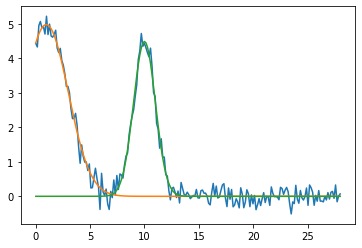

In [707]:
#import Fit
x = np.linspace(0,28,200)
y = Fit.gaussian(x,5,1,2)+Fit.gaussian(x,4.5,10,1)+np.random.normal(0,0.2,200)
plt.plot(x,y)
fits, bkg_fit =Fit.lazyGaussianFit(x,y,USEBKG=False)
#LIN_BOUNDS=([-0.2,-np.inf],[0.2,np.inf]
print(fits)
for i in tqdm(range(len(fits))):
    fit=fits[i]
    if fit is not None:
        y2=Fit.gaussian(x,fit[0],fit[1],fit[2])
        #y3=Fit.line(x,bkg_fit[0],bkg_fit[1])
        plt.plot(x,y2)

[7.40425221e+01 2.39718785e-03 2.11219126e-04]


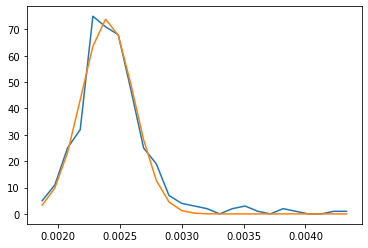

In [708]:
x,val,fit = Fit.timeResolution(data.CTR)
print(fit)
plt.plot(x,val)
if fit is not None:
    plt.plot(x,Fit.gaussian(x,fit[0],fit[1],fit[2]))

[99.46756769  3.17612646  0.39070016]


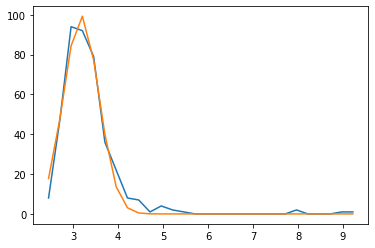

In [709]:
x,val,fit,p = Fit.energyResolution(data.E_ResR)
print(fit)
plt.plot(x,val)
if fit is not None:
    plt.plot(x,Fit.gaussian(x,fit[0],fit[1],fit[2]))

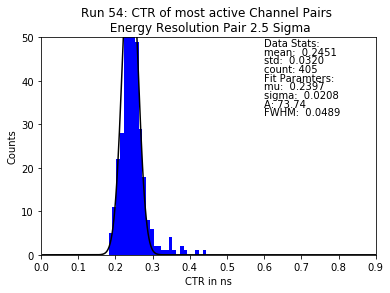

In [694]:
### plotting all the CTRS
CTRs = data.CTR
CTRs = CTRs.abs()
fig1 = plt.figure()
ax1 = fig1.add_subplot(111,xlim=(0,0.9), ylim=(0,50),xlabel="CTR in ns",ylabel="Counts",title="Run "+str(run_num)+": CTR of most active Channel Pairs \n Energy Resolution Pair 2.5 Sigma")

low = 0
high = low +1 #high = low * -1
num_bins = 100
bins = np.linspace(low,high,num_bins)
x = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),num_bins-1)
y1 = CTRs.value_counts(bins=bins,sort=False).tolist()
x1_p, x1_co = curve_fit(gauss,x,y1, p0=[75,CTRs.mean(),CTRs.std()])


x_p = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),400)
T_x = 0.6
T_y = generateTextY(9,50)

ax1.hist(CTRs, bins=bins,color='b')
ax1.plot(x_p,gauss(x_p,x1_p[0],x1_p[1],x1_p[2]), color='k')
ax1.text(T_x,T_y[0],"Data Stats:")
ax1.text(T_x,T_y[1],"mean: "+format(CTRs.mean(),"7.4f"))
ax1.text(T_x,T_y[2],"std: "+format(CTRs.std(),"7.4f"))
ax1.text(T_x,T_y[3],"count: "+str(len(CTRs)))
ax1.text(T_x,T_y[4],"Fit Paramters:")
ax1.text(T_x,T_y[5],"mu: "+format(x1_p[1],"7.4f"))
ax1.text(T_x,T_y[6],"sigma: "+format(x1_p[2],"7.4f"))
ax1.text(T_x,T_y[7],"A: "+format(x1_p[0],"5.2f"))
ax1.text(T_x,T_y[8],"FWHM: "+format(2.3548* x1_p[2],"7.4f"))
plt.savefig(pltdir+"CTR.png")
plt.show()

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

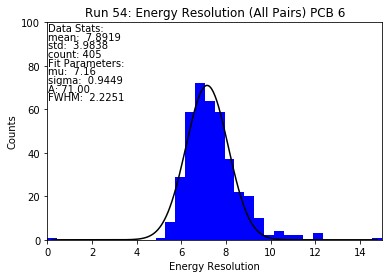

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  2.87it/s]

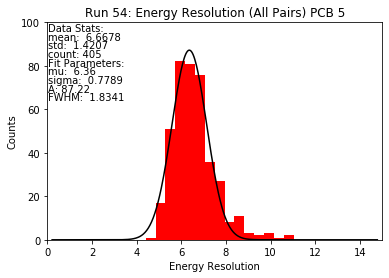

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


In [8]:
lr = ["PCB 6","PCB 5"]
colors = ['b','r']
for i in tqdm(range(2)):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111,xlim=(0,15), ylim=(0,100),xlabel="Energy Resolution",ylabel="Counts",title="Run "+str(run_num)+": Energy Resolution (All Pairs) "+lr[i])
    if (i==0):
        dataK = data.E_ResL
    else:
        dataK = data.E_ResR
    low = 0
    high = low +15 #high = low * -1
    num_bins = 35
    bins = np.linspace(low,high,num_bins)
    x = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),num_bins-1)
    y1 = dataK.value_counts(bins=bins,sort=False).tolist()
    fitted = True
    try:
        x1_p, x1_co = curve_fit(gauss,x,y1, p0=[75,dataK.mean(),dataK.std()])
    except:
        print("E_Res FIT FAILED")
        fitted = False

    x_p = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),400)
    T_x = 0.05
    T_y = generateTextY(9,100)

    ax1.hist(dataK, bins=bins,color=colors[i])
    ax1.plot(x_p,gauss(x_p,x1_p[0],x1_p[1],x1_p[2]), color='k')
    ax1.text(T_x,T_y[0],"Data Stats:")
    ax1.text(T_x,T_y[1],"mean: "+format(dataK.mean(),"7.4f"))
    ax1.text(T_x,T_y[2],"std: "+format(dataK.std(),"7.4f"))
    ax1.text(T_x,T_y[3],"count: "+str(len(dataK)))
    if(fitted):
        ax1.text(T_x,T_y[4],"Fit Parameters:")
        ax1.text(T_x,T_y[5],"mu: "+format(x1_p[1],"5.2f"))
        ax1.text(T_x,T_y[6],"sigma: "+format(x1_p[2],"7.4f"))
        ax1.text(T_x,T_y[7],"A: "+format(x1_p[0],"5.2f"))
        ax1.text(T_x,T_y[8],"FWHM: "+format(2.3548* x1_p[2],"7.4f"))
    else:
        ax1.text(T_x,T_y[4],"Fit FAILED")
    plt.savefig(pltdir+"Energy Resolution"+lr[i]+".png")
    plt.show()
    plt.clf()
    plt.close()

In [60]:

PP_P = pd.DataFrame()
PP_P["ChannelIDL"] = df["ChannelIDL"]
PP_P["ChannelIDR"] = df["ChannelIDR"]
PP_P["Count"] = df["PP_Count"]
PP_L = PP_P.groupby("ChannelIDL").Count.sum().reset_index()
PP_L.columns = ["ChannelIDL", "Counts"]
PP_R = PP_P.groupby("ChannelIDR").Count.sum().reset_index()
PP_R.columns = ["ChannelIDR", "Counts"]


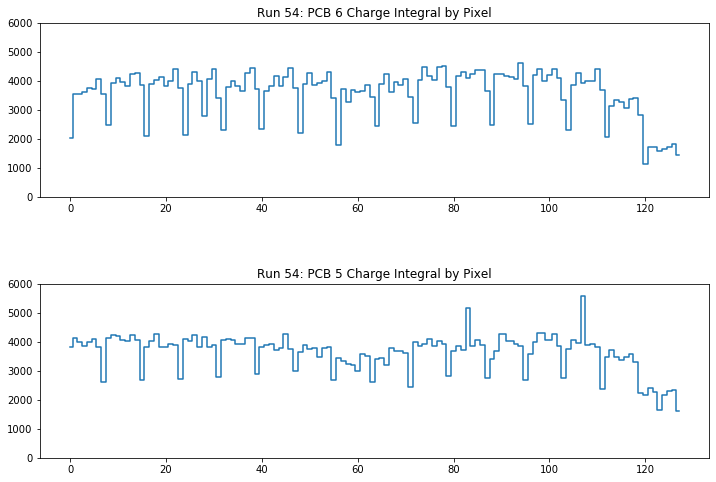

In [61]:
#Charge Integration
#converting software to geometry
#for i in range(0,E_Int.ChannelID.count()):
#     E_Int["ChannelID"][i] = 8*indices.get(E_Int["ChannelID"][i])[0] + indices.get(E_Int["ChannelID"][i])[1]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
ax.set_title("Run "+str(run_num)+": PCB 6 Charge Integral by Pixel")
ax1.set_title("Run "+str(run_num)+": PCB 5 Charge Integral by Pixel")
ax.set_ylim(0,6000)
ax1.set_ylim(0,6000)
#ax.scatter(E_Int.ChannelID, E_Int.Charge_INTR)
#ax1.scatter(E_Int.ChannelID, E_Int.Charge_INTL)
dataCI = df.groupby("GeoChannelIDL").QINTL.sum().reset_index()
ax.step(dataCI["GeoChannelIDL"], dataCI["QINTL"], where='mid')
dataCI = df.groupby("GeoChannelIDR").QINTR.sum().reset_index()
ax1.step(dataCI["GeoChannelIDR"], dataCI["QINTR"], where='mid')
plt.subplots_adjust(hspace=0.5)
plt.savefig(pltdir+"Charge_Integration.png")
plt.show()

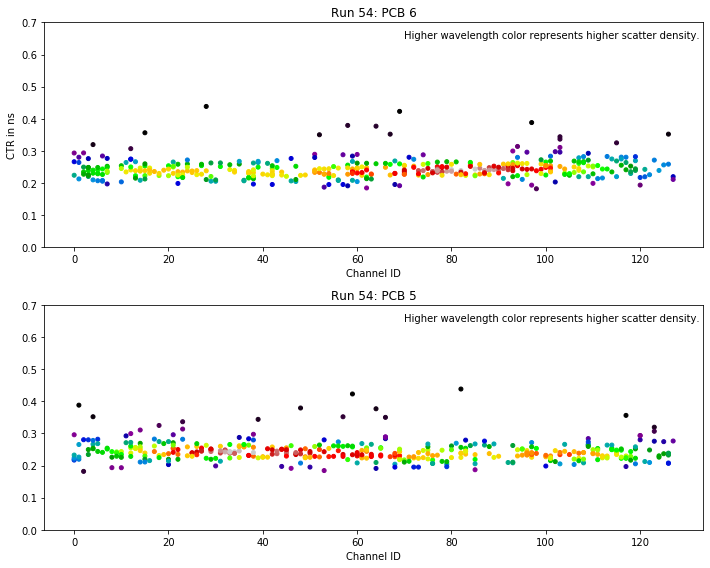

In [62]:
#CTR by Channel ID geometric
fig, [ax,ax1] = plt.subplots(2,figsize = (10,8),tight_layout=True)

# Calculate the point density
xy = np.vstack([a,data["CTR"]])
z = gaussian_kde(xy)(xy)
ax.scatter(a,data["CTR"], c=z, s=16, cmap = "nipy_spectral")

xy = np.vstack([b,data["CTR"]])
z = gaussian_kde(xy)(xy)
ax1.scatter(b, data["CTR"], c=z, s=16, cmap = "nipy_spectral")

ax.set_ylabel("CTR in ns")
ax.set_xlabel("Channel ID")
ax1.set_xlabel("Channel ID")
ax.text(70,0.65,"Higher wavelength color represents higher scatter density.")
ax1.text(70,0.65,"Higher wavelength color represents higher scatter density.")
ax.set_ylim(0.0,0.7) #0.2, 0.37
ax1.set_ylim(0.0,0.7)
ax.set_title("Run "+str(run_num)+": PCB 6")
ax1.set_title("Run "+str(run_num)+": PCB 5")
plt.savefig(pltdir+"CTR_Histogram.png")
plt.show()

In [63]:
# Best CTR by pixel on a heatmap
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('binary')

N = 128
vals = np.ones((2*N, 4))
# vals[:, 0] = np.linspace(100/(256), 0.5, N).tolist()+np.linspace(0.5, 0.9, N).tolist()
# vals[:, 1] = np.linspace(166/(256), 0.5, N).tolist()+np.linspace(0.5, 0.7, N).tolist()
# vals[:, 2] = np.linspace(255/(256), 0.7, N).tolist()+np.linspace(0.7, 0.9, N).tolist()
# vals[:, 0] = np.linspace(0.3, 0.5, N).tolist()+np.linspace(0.5, 1, N).tolist()
# vals[:, 1] = np.linspace(0.3, 0.5, N).tolist()+np.linspace(0.5, 1, N).tolist()
# vals[:, 2] = np.linspace(1, 0.7, N).tolist()+np.linspace(0.7, 1, N).tolist()
# new_cmap = colors.ListedColormap(vals)

new_cmap = plt.get_cmap('binary')
cr = 'k'#'#4b6ad3'
thdl_C = 260
thdl_E = 4
#cr1 = '#0000ff'
#cr2 = '#ffffff'
# cr1 = 'k'
# cr2='k'
cr1 ='b'
cr2='b'
#new_cmap = plt.get_cmap('pink')#truncate_colormap(cmap, 0.2, 0.8)

CTRL = data.groupby("GeoChannelIDL").CTR.min().reset_index()
CTRL.columns = ["ChannelIDL", "CTR"]
CTRL["CTR"] = 1000*CTRL["CTR"]
#I know there is a better way to do this but this is just a quick method, feel free to suggest an improvment
for i in range(0,128):
    run = CTRL[CTRL["ChannelIDL"] == i]
    if run.ChannelIDL.count() == 0:
        CTRL = CTRL.append({"ChannelIDL":i, "CTR":0},ignore_index=True)

CTRR = data.groupby("GeoChannelIDR").CTR.min().reset_index()
CTRR.columns = ["ChannelIDR", "CTR"]
CTRR["CTR"] = 1000*CTRR["CTR"]
for i in range(0,128):
    run = CTRR[CTRR["ChannelIDR"] == i]
    if run.ChannelIDR.count() == 0:
        CTRR = CTRR.append({"ChannelIDR":i, "CTR":0},ignore_index=True)

CTRL = CTRL.sort_values(by="ChannelIDL")
CTRR = CTRR.sort_values(by="ChannelIDR")

CTRRT = CTRR[CTRR["ChannelIDR"] < 64].reset_index(drop=True)
CTRRB = CTRR[CTRR["ChannelIDR"] >= 64].reset_index(drop=True)
CTRLT = CTRL[CTRL["ChannelIDL"] < 64].reset_index(drop=True)
CTRLB = CTRL[CTRL["ChannelIDL"] >= 64].reset_index(drop=True)

In [64]:
CTRLT.CTR = 0.001* CTRLT.CTR
CTRRT.CTR = 0.001* CTRRT.CTR
CTRLB.CTR = 0.001* CTRLB.CTR
CTRRB.CTR = 0.001* CTRRB.CTR

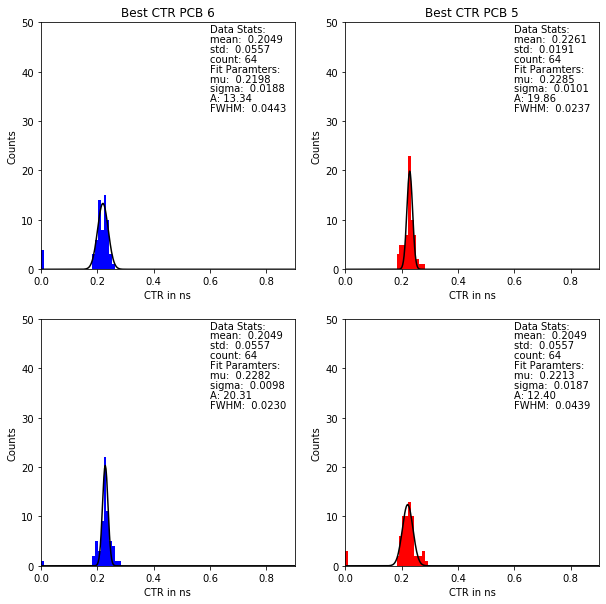

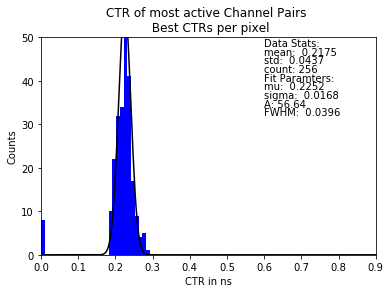

In [65]:
# on a histogram for each array
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(221,xlim=(0,0.9), ylim=(0,50),xlabel="CTR in ns",ylabel="Counts",title="Best CTR PCB 6")
ax2 = fig1.add_subplot(222,xlim=(0,0.9), ylim=(0,50),xlabel="CTR in ns",ylabel="Counts",title="Best CTR PCB 5")
ax3 = fig1.add_subplot(223,xlim=(0,0.9), ylim=(0,50),xlabel="CTR in ns",ylabel="Counts")
ax4 = fig1.add_subplot(224,xlim=(0,0.9), ylim=(0,50),xlabel="CTR in ns",ylabel="Counts")

low = 0
high = low +1 #high = low * -1
num_bins = 100
bins = np.linspace(low,high,num_bins)
x = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),num_bins-1)
y1 = CTRLT.CTR.value_counts(bins=bins,sort=False).tolist()
y2 = CTRRT.CTR.value_counts(bins=bins,sort=False).tolist()
y3 = CTRLB.CTR.value_counts(bins=bins,sort=False).tolist()
y4 = CTRRB.CTR.value_counts(bins=bins,sort=False).tolist()
x1_p, x1_co = curve_fit(gauss,x,y1, p0=[75,CTRLT.CTR.mean(),CTRLT.CTR.std()])
x2_p, x2_co = curve_fit(gauss,x,y2, p0=[75,CTRRT.CTR.mean(),CTRRT.CTR.std()])
x3_p, x3_co = curve_fit(gauss,x,y3, p0=[75,CTRLB.CTR.mean(),CTRLB.CTR.std()])
x4_p, x4_co = curve_fit(gauss,x,y4, p0=[75,CTRRB.CTR.mean(),CTRRB.CTR.std()])


x_p = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),400)
T_x = 0.6
T_y = generateTextY(9,50)

ax1.hist(CTRLT.CTR, bins=bins,color='b')
ax1.plot(x_p,gauss(x_p,x1_p[0],x1_p[1],x1_p[2]), color='k')
ax1.text(T_x,T_y[0],"Data Stats:")
ax1.text(T_x,T_y[1],"mean: "+format(CTRLT.CTR.mean(),"7.4f"))
ax1.text(T_x,T_y[2],"std: "+format(CTRLT.CTR.std(),"7.4f"))
ax1.text(T_x,T_y[3],"count: "+str(CTRLT.CTR.count()))
ax1.text(T_x,T_y[4],"Fit Paramters:")
ax1.text(T_x,T_y[5],"mu: "+format(x1_p[1],"7.4f"))
ax1.text(T_x,T_y[6],"sigma: "+format(x1_p[2],"7.4f"))
ax1.text(T_x,T_y[7],"A: "+format(x1_p[0],"5.2f"))
ax1.text(T_x,T_y[8],"FWHM: "+format(2.3548* x1_p[2],"7.4f"))

ax2.hist(CTRRT.CTR, bins=bins,color='r')
ax2.plot(x_p,gauss(x_p,x2_p[0],x2_p[1],x2_p[2]), color='k')
ax2.text(T_x,T_y[0],"Data Stats:")
ax2.text(T_x,T_y[1],"mean: "+format(CTRRT.CTR.mean(),"7.4f"))
ax2.text(T_x,T_y[2],"std: "+format(CTRRT.CTR.std(),"7.4f"))
ax2.text(T_x,T_y[3],"count: "+str(CTRRT.CTR.count()))
ax2.text(T_x,T_y[4],"Fit Paramters:")
ax2.text(T_x,T_y[5],"mu: "+format(x2_p[1],"7.4f"))
ax2.text(T_x,T_y[6],"sigma: "+format(x2_p[2],"7.4f"))
ax2.text(T_x,T_y[7],"A: "+format(x2_p[0],"5.2f"))
ax2.text(T_x,T_y[8],"FWHM: "+format(2.3548* x2_p[2],"7.4f"))

ax3.hist(CTRLB.CTR, bins=bins,color='b')
ax3.plot(x_p,gauss(x_p,x3_p[0],x3_p[1],x3_p[2]), color='k')
ax3.text(T_x,T_y[0],"Data Stats:")
ax3.text(T_x,T_y[1],"mean: "+format(CTRLT.CTR.mean(),"7.4f"))
ax3.text(T_x,T_y[2],"std: "+format(CTRLT.CTR.std(),"7.4f"))
ax3.text(T_x,T_y[3],"count: "+str(CTRLT.CTR.count()))
ax3.text(T_x,T_y[4],"Fit Paramters:")
ax3.text(T_x,T_y[5],"mu: "+format(x3_p[1],"7.4f"))
ax3.text(T_x,T_y[6],"sigma: "+format(x3_p[2],"7.4f"))
ax3.text(T_x,T_y[7],"A: "+format(x3_p[0],"5.2f"))
ax3.text(T_x,T_y[8],"FWHM: "+format(2.3548* x3_p[2],"7.4f"))

ax4.hist(CTRRB.CTR, bins=bins,color='r')
ax4.plot(x_p,gauss(x_p,x4_p[0],x4_p[1],x4_p[2]), color='k')
ax4.text(T_x,T_y[0],"Data Stats:")
ax4.text(T_x,T_y[1],"mean: "+format(CTRLT.CTR.mean(),"7.4f"))
ax4.text(T_x,T_y[2],"std: "+format(CTRLT.CTR.std(),"7.4f"))
ax4.text(T_x,T_y[3],"count: "+str(CTRLT.CTR.count()))
ax4.text(T_x,T_y[4],"Fit Paramters:")
ax4.text(T_x,T_y[5],"mu: "+format(x4_p[1],"7.4f"))
ax4.text(T_x,T_y[6],"sigma: "+format(x4_p[2],"7.4f"))
ax4.text(T_x,T_y[7],"A: "+format(x4_p[0],"5.2f"))
ax4.text(T_x,T_y[8],"FWHM: "+format(2.3548* x4_p[2],"7.4f"))

plt.savefig(pltdir+"Best CTR By Array.jpg")
plt.show()

# on a single histogram
oof = pd.concat([CTRLT, CTRLB, CTRRT, CTRRB], ignore_index=True)
CTRs = oof.CTR
CTRs = CTRs.abs()
fig1 = plt.figure()
ax1 = fig1.add_subplot(111,xlim=(0,0.9), ylim=(0,50),xlabel="CTR in ns",ylabel="Counts",title="CTR of most active Channel Pairs \n Best CTRs per pixel")

low = 0
high = low +1 #high = low * -1
num_bins = 100
bins = np.linspace(low,high,num_bins)
x = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),num_bins-1)
y1 = CTRs.value_counts(bins=bins,sort=False).tolist()
x1_p, x1_co = curve_fit(gauss,x,y1, p0=[75,CTRs.mean(),CTRs.std()])


x_p = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),400)
T_x = 0.6
T_y = generateTextY(9,50)

ax1.hist(CTRs, bins=bins,color='b')
ax1.plot(x_p,gauss(x_p,x1_p[0],x1_p[1],x1_p[2]), color='k')
ax1.text(T_x,T_y[0],"Data Stats:")
ax1.text(T_x,T_y[1],"mean: "+format(CTRs.mean(),"7.4f"))
ax1.text(T_x,T_y[2],"std: "+format(CTRs.std(),"7.4f"))
ax1.text(T_x,T_y[3],"count: "+str(len(CTRs)))
ax1.text(T_x,T_y[4],"Fit Paramters:")
ax1.text(T_x,T_y[5],"mu: "+format(x1_p[1],"7.4f"))
ax1.text(T_x,T_y[6],"sigma: "+format(x1_p[2],"7.4f"))
ax1.text(T_x,T_y[7],"A: "+format(x1_p[0],"5.2f"))
ax1.text(T_x,T_y[8],"FWHM: "+format(2.3548* x1_p[2],"7.4f"))
plt.savefig(pltdir+"Best CTR.jpg")
plt.show()


In [66]:
CTRLT.CTR = 1000* CTRLT.CTR
CTRRT.CTR = 1000* CTRRT.CTR
CTRLB.CTR = 1000* CTRLB.CTR
CTRRB.CTR = 1000* CTRRB.CTR

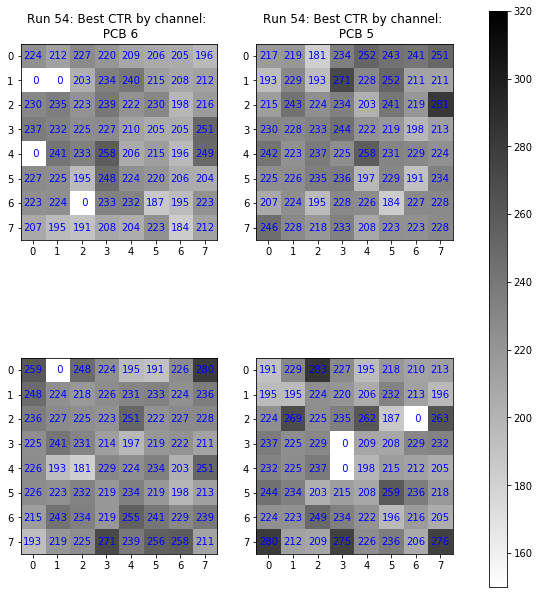

In [67]:
CTRLT = np.reshape(np.array(CTRLT.CTR), (8,8))
CTRLB = np.reshape(np.array(CTRLB.CTR), (8,8))
CTRRT = np.reshape(np.array(CTRRT.CTR), (8,8))
CTRRB = np.reshape(np.array(CTRRB.CTR), (8,8))

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.xticks(np.arange(8))
plt.yticks(np.arange(8))
for i in range(8):
    for j in range(8):
        if(CTRLT[i][j] < thdl_C):
            cr = cr1
        else:
            cr = cr2
        plt.text(j, i, format(int(CTRLT[i][j]),"3"), ha="center", va="center", color=cr)
plt.title("Run "+str(run_num)+": Best CTR by channel: \n PCB 6")
plt.imshow(CTRLT,cmap=new_cmap,vmin=150, vmax=320)

plt.subplot(222)
plt.xticks(np.arange(8))
plt.yticks(np.arange(8))
for i in range(8):
    for j in range(8):
        if(CTRRT[i][j] < thdl_C):
            cr = cr1
        else:
            cr = cr2
        plt.text(j, i, format(int(CTRRT[i][j]),"3"), ha="center", va="center", color=cr)
plt.title("Run "+str(run_num)+": Best CTR by channel: \n PCB 5")
plt.imshow(CTRRT,cmap=new_cmap,vmin=150, vmax=320)

plt.subplot(223)
plt.xticks(np.arange(8))
plt.yticks(np.arange(8))
for i in range(8):
    for j in range(8):
        if(CTRLB[i][j] < thdl_C):
            cr = cr1
        else:
            cr = cr2
        plt.text(j, i, format(int(CTRLB[i][j]),"3"), ha="center", va="center", color=cr)
plt.imshow(CTRLB,cmap=new_cmap,vmin=150, vmax=320)

plt.subplot(224)
plt.xticks(np.arange(8))
plt.yticks(np.arange(8))
for i in range(8):
    for j in range(8):
        if(CTRRB[i][j] < thdl_C):
            cr = cr1
        else:
            cr = cr2
        plt.text(j, i, format(int(CTRRB[i][j]),"3"), ha="center", va="center", color=cr)
plt.imshow(CTRRB,cmap=new_cmap,vmin=150, vmax=320)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9,left=0.2)
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)
plt.savefig(pltdir+"CTR Heatmap.png")
plt.show()

In [68]:
# Best ERes by pixel on a heatmap
EResL = data.groupby("GeoChannelIDL").E_ResL.min().reset_index()
EResL.columns = ["ChannelIDL", "ERes"]
#I know there is a better way to do this but this is just a quick method, feel free to suggest an improvment
for i in range(0,128):
    run = EResL[EResL["ChannelIDL"] == i]
    if run.ChannelIDL.count() == 0:
        EResL = EResL.append({"ChannelIDL":i, "ERes":0},ignore_index=True)

EResR = data.groupby("GeoChannelIDR").E_ResR.min().reset_index()
EResR.columns = ["ChannelIDR", "ERes"]
for i in range(0,128):
    run = EResR[EResR["ChannelIDR"] == i]
    if run.ChannelIDR.count() == 0:
        EResR = EResR.append({"ChannelIDR":i, "ERes":0},ignore_index=True)

EResL = EResL.sort_values(by="ChannelIDL")
EResR = EResR.sort_values(by="ChannelIDR")

EResRT = EResR[EResR["ChannelIDR"] < 64].reset_index(drop=True)
EResRB = EResR[EResR["ChannelIDR"] >= 64].reset_index(drop=True)
EResLT = EResL[EResL["ChannelIDL"] < 64].reset_index(drop=True)
EResLB = EResL[EResL["ChannelIDL"] >= 64].reset_index(drop=True)

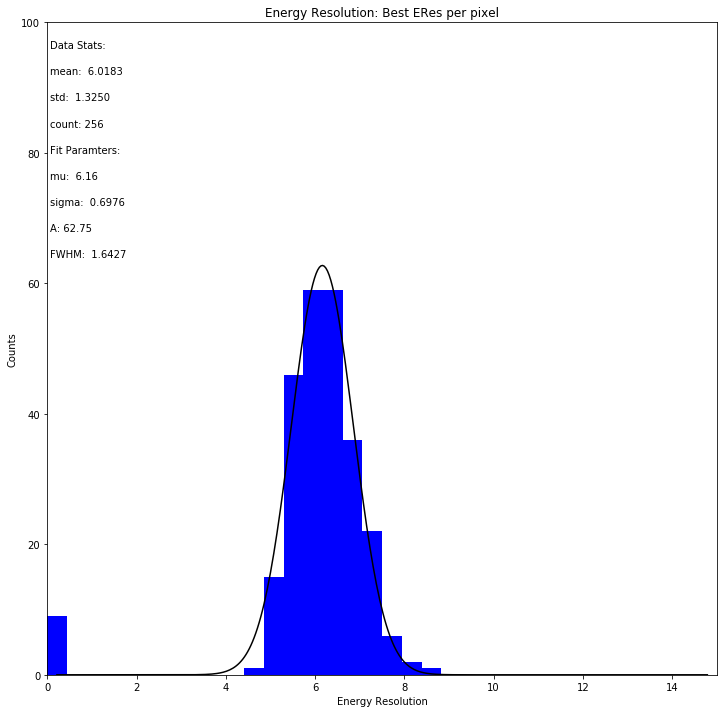

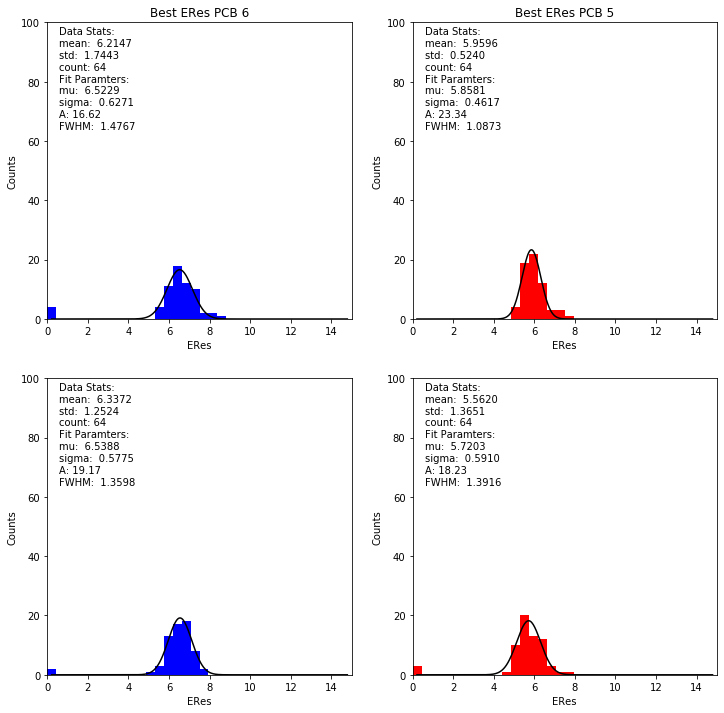

In [69]:
# on a single histogram
oof = pd.concat([EResLT, EResLB, EResRT, EResRB], ignore_index=True)
fig1 = plt.figure(figsize=(12,12))
ax1 = fig1.add_subplot(111,xlim=(0,15), ylim=(0,100),xlabel="Energy Resolution",ylabel="Counts",title="Energy Resolution: Best ERes per pixel")

data = oof.ERes
low = 0
high = low +15 #high = low * -1
num_bins = 35
bins = np.linspace(low,high,num_bins)
x = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),num_bins-1)
y1 = data.value_counts(bins=bins,sort=False).tolist()
x1_p, x1_co = curve_fit(gauss,x,y1, p0=[75,data.mean(),data.std()])


x_p = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),400)
T_x = 0.05
T_y = generateTextY(9,100)

ax1.hist(data, bins=bins,color='b')
ax1.plot(x_p,gauss(x_p,x1_p[0],x1_p[1],x1_p[2]), color='k')
ax1.text(T_x,T_y[0],"Data Stats:")
ax1.text(T_x,T_y[1],"mean: "+format(data.mean(),"7.4f"))
ax1.text(T_x,T_y[2],"std: "+format(data.std(),"7.4f"))
ax1.text(T_x,T_y[3],"count: "+str(len(data)))
ax1.text(T_x,T_y[4],"Fit Paramters:")
ax1.text(T_x,T_y[5],"mu: "+format(x1_p[1],"5.2f"))
ax1.text(T_x,T_y[6],"sigma: "+format(x1_p[2],"7.4f"))
ax1.text(T_x,T_y[7],"A: "+format(x1_p[0],"5.2f"))
ax1.text(T_x,T_y[8],"FWHM: "+format(2.3548* x1_p[2],"7.4f"))
plt.savefig(pltdir+"Best Energy Resolution.jpg")
plt.show()


# on a histogram for each array
fig1 = plt.figure(figsize=(12,12))
ax1 = fig1.add_subplot(221,xlim=(0,15), ylim=(0,100),xlabel="ERes",ylabel="Counts",title="Best ERes PCB 6")
ax2 = fig1.add_subplot(222,xlim=(0,15), ylim=(0,100),xlabel="ERes",ylabel="Counts",title="Best ERes PCB 5")
ax3 = fig1.add_subplot(223,xlim=(0,15), ylim=(0,100),xlabel="ERes",ylabel="Counts")
ax4 = fig1.add_subplot(224,xlim=(0,15), ylim=(0,100),xlabel="ERes",ylabel="Counts")

low = 0
high = low +15 #high = low * -1
num_bins = 35
bins = np.linspace(low,high,num_bins)
x = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),num_bins-1)
y1 = EResLT.ERes.value_counts(bins=bins,sort=False).tolist()
y2 = EResRT.ERes.value_counts(bins=bins,sort=False).tolist()
y3 = EResLB.ERes.value_counts(bins=bins,sort=False).tolist()
y4 = EResRB.ERes.value_counts(bins=bins,sort=False).tolist()
x1_p, x1_co = curve_fit(gauss,x,y1, p0=[75,EResLT.ERes.mean(),EResLT.ERes.std()])
x2_p, x2_co = curve_fit(gauss,x,y2, p0=[75,EResRT.ERes.mean(),EResRT.ERes.std()])
x3_p, x3_co = curve_fit(gauss,x,y3, p0=[75,EResLB.ERes.mean(),EResLB.ERes.std()])
x4_p, x4_co = curve_fit(gauss,x,y4, p0=[75,EResRB.ERes.mean(),EResRB.ERes.std()])


x_p = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),400)
T_x = 0.6
T_y = generateTextY(9,100)

ax1.hist(EResLT.ERes, bins=bins,color='b')
ax1.plot(x_p,gauss(x_p,x1_p[0],x1_p[1],x1_p[2]), color='k')
ax1.text(T_x,T_y[0],"Data Stats:")
ax1.text(T_x,T_y[1],"mean: "+format(EResLT.ERes.mean(),"7.4f"))
ax1.text(T_x,T_y[2],"std: "+format(EResLT.ERes.std(),"7.4f"))
ax1.text(T_x,T_y[3],"count: "+str(EResLT.ERes.count()))
ax1.text(T_x,T_y[4],"Fit Paramters:")
ax1.text(T_x,T_y[5],"mu: "+format(x1_p[1],"7.4f"))
ax1.text(T_x,T_y[6],"sigma: "+format(x1_p[2],"7.4f"))
ax1.text(T_x,T_y[7],"A: "+format(x1_p[0],"5.2f"))
ax1.text(T_x,T_y[8],"FWHM: "+format(2.3548* x1_p[2],"7.4f"))

ax2.hist(EResRT.ERes, bins=bins,color='r')
ax2.plot(x_p,gauss(x_p,x2_p[0],x2_p[1],x2_p[2]), color='k')
ax2.text(T_x,T_y[0],"Data Stats:")
ax2.text(T_x,T_y[1],"mean: "+format(EResRT.ERes.mean(),"7.4f"))
ax2.text(T_x,T_y[2],"std: "+format(EResRT.ERes.std(),"7.4f"))
ax2.text(T_x,T_y[3],"count: "+str(EResRT.ERes.count()))
ax2.text(T_x,T_y[4],"Fit Paramters:")
ax2.text(T_x,T_y[5],"mu: "+format(x2_p[1],"7.4f"))
ax2.text(T_x,T_y[6],"sigma: "+format(x2_p[2],"7.4f"))
ax2.text(T_x,T_y[7],"A: "+format(x2_p[0],"5.2f"))
ax2.text(T_x,T_y[8],"FWHM: "+format(2.3548* x2_p[2],"7.4f"))

ax3.hist(EResLB.ERes, bins=bins,color='b')
ax3.plot(x_p,gauss(x_p,x3_p[0],x3_p[1],x3_p[2]), color='k')
ax3.text(T_x,T_y[0],"Data Stats:")
ax3.text(T_x,T_y[1],"mean: "+format(EResLB.ERes.mean(),"7.4f"))
ax3.text(T_x,T_y[2],"std: "+format(EResLB.ERes.std(),"7.4f"))
ax3.text(T_x,T_y[3],"count: "+str(EResLB.ERes.count()))
ax3.text(T_x,T_y[4],"Fit Paramters:")
ax3.text(T_x,T_y[5],"mu: "+format(x3_p[1],"7.4f"))
ax3.text(T_x,T_y[6],"sigma: "+format(x3_p[2],"7.4f"))
ax3.text(T_x,T_y[7],"A: "+format(x3_p[0],"5.2f"))
ax3.text(T_x,T_y[8],"FWHM: "+format(2.3548* x3_p[2],"7.4f"))

ax4.hist(EResRB.ERes, bins=bins,color='r')
ax4.plot(x_p,gauss(x_p,x4_p[0],x4_p[1],x4_p[2]), color='k')
ax4.text(T_x,T_y[0],"Data Stats:")
ax4.text(T_x,T_y[1],"mean: "+format(EResRB.ERes.mean(),"7.4f"))
ax4.text(T_x,T_y[2],"std: "+format(EResRB.ERes.std(),"7.4f"))
ax4.text(T_x,T_y[3],"count: "+str(EResRB.ERes.count()))
ax4.text(T_x,T_y[4],"Fit Paramters:")
ax4.text(T_x,T_y[5],"mu: "+format(x4_p[1],"7.4f"))
ax4.text(T_x,T_y[6],"sigma: "+format(x4_p[2],"7.4f"))
ax4.text(T_x,T_y[7],"A: "+format(x4_p[0],"5.2f"))
ax4.text(T_x,T_y[8],"FWHM: "+format(2.3548* x4_p[2],"7.4f"))
plt.savefig(pltdir+"Best Energy Resolution By Array.jpg")
plt.show()

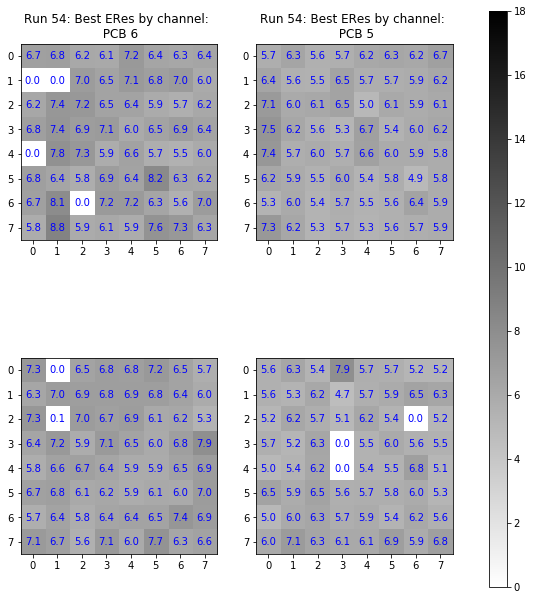

In [70]:
EResLT = np.reshape(np.array(EResLT.ERes), (8,8))
EResLB = np.reshape(np.array(EResLB.ERes), (8,8))
EResRT = np.reshape(np.array(EResRT.ERes), (8,8))
EResRB = np.reshape(np.array(EResRB.ERes), (8,8))
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.xticks(np.arange(8))
plt.yticks(np.arange(8))
for i in range(8):
    for j in range(8):
        if(EResLT[i][j] < thdl_E):
            cr = cr1
        else:
            cr = cr2
        plt.text(j, i, format(EResLT[i][j],".1f"), ha="center", va="center", color=cr)
plt.title("Run "+str(run_num)+": Best ERes by channel: \n PCB 6")
plt.imshow(EResLT,cmap=new_cmap,vmin=0.0, vmax=18.0)

plt.subplot(222)
plt.xticks(np.arange(8))
plt.yticks(np.arange(8))
for i in range(8):
    for j in range(8):
        if(EResRT[i][j] < thdl_E):
            cr = cr1
        else:
            cr = cr2
        plt.text(j, i, format(EResRT[i][j],".1f"), ha="center", va="center", color=cr)
plt.title("Run "+str(run_num)+": Best ERes by channel: \n PCB 5")
plt.imshow(EResRT,cmap=new_cmap,vmin=0.0, vmax=18.0)

plt.subplot(223)
plt.xticks(np.arange(8))
plt.yticks(np.arange(8))
for i in range(8):
    for j in range(8):
        if(EResLB[i][j] < thdl_E):
            cr = cr1
        else:
            cr = cr2
        plt.text(j, i, format(EResLB[i][j],".1f"), ha="center", va="center", color=cr)
plt.imshow(EResLB,cmap=new_cmap,vmin=0.0, vmax=18.0)

plt.subplot(224)
plt.xticks(np.arange(8))
plt.yticks(np.arange(8))
for i in range(8):
    for j in range(8):
        if(EResRB[i][j] < thdl_E):
            cr = cr1
        else:
            cr = cr2
        plt.text(j, i, format(EResRB[i][j],".1f"), ha="center", va="center", color=cr)
plt.imshow(EResRB,cmap=new_cmap,vmin=0.0, vmax=18.0)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9,left=0.2)
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)
plt.savefig(pltdir+"Energy Heatmap")
plt.show()

In [ ]:
df1

In [128]:
len(CTRs)

300

In [103]:
np.mean(ERes)

17.26982598841991

In [104]:
np.mean(EResR)

17.35493464790535

In [105]:
print(np.mean(CTRs))
print(np.median(CTRs))

0.28005576853977454
0.27789505021441974


In [106]:
# CTR histogram
binwidth = 0.01
LR = ["Left PCB", "Right PCB"]
fig,axs = plt.subplots(1,tight_layout = True,figsize=(5,5))

axs.set_title(run_name+" CTR")
pairctr = CTRs
ranges = max(pairctr) - min(pairctr)
mean = np.mean(pairctr)
std = np.std(pairctr)
axs.hist(pairctr,bins = int(ranges/binwidth), color = 'blue')
axs.set_xlim(0,0.4)
axs.set_ylabel("Lines of Response (LORs)")
axs.set_xlabel("CTR in ns")
axs.text(0.01,0.95,"Number of LORs : "+str(len(CTRs))+" of 128^2 channels",verticalalignment='top',horizontalalignment='left',transform=axs.transAxes,fontsize=10)
axs.text(0.01,0.90,"Binwidth : "+str(binwidth)+" ns",verticalalignment='top',horizontalalignment='left',transform=axs.transAxes,fontsize=10)
axs.text(0.01,0.85,"Data : Mean="+format(mean,'7.4f')+", STD="+format(std,'7.4f')+" ns",verticalalignment='top',horizontalalignment='left',transform=axs.transAxes,fontsize=10)

hist,bin_edges = np.histogram(pairctr,bins = len(pairctr))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
maximum = np.max(hist)
fitp, fitcov = curve_fit(gauss,bin_centres,hist,p0=[maximum,mean,std])
xs = np.linspace(min(pairctr),max(pairctr),100)
axs.plot(xs,gauss(xs,(binwidth*len(pairctr)/ranges)*fitp[0],fitp[1],fitp[2]),color='black')
axs.text(0.01,0.80,"Fit : Mean="+format(fitp[1],'7.4f')+", STD="+format(fitp[2],'7.4f')+",\n       FWHM="+format(2.3548*fitp[2],'7.4f')+" ns",verticalalignment='top',horizontalalignment='left',transform=axs.transAxes,fontsize=10) 

plt.savefig(plot_dir+"CTR.jpg")
plt.close()

In [107]:
# ERES by PCB histogram
binwidth = 2
LR = ["Left PCB (#6) - Blue", "Right PCB (#5) - Red"]
colors = ["blue","red"]
alpha = 0.4
fig,axs = plt.subplots(1,2,constrained_layout = True,figsize=(10,4))
Eres = [ERes,EResR]
shift = 0.35
ranges = 50
plt.suptitle(run_name+" Energy Resolution")
for i in range(2):
    pairctr = np.array(Eres[i])
    mean = np.mean(pairctr)
    median = np.median(pairctr)
    std = np.std(pairctr)
    axs[i].hist(pairctr,bins = int(ranges/binwidth), range = [0, ranges], color = colors[i], alpha = alpha)
    axs[i].set_xlim(0,ranges)
    axs[i].set_ylabel("Pixels")
    axs[i].set_xlabel("Energy Resolution (%)")
    axs[i].set_title(LR[i])
    axs[i].text(0.33,.99,"Number of Pixels : "+str(len(CTRs))+" of 128",verticalalignment='top',horizontalalignment='left',transform=axs[i].transAxes,fontsize=10)
    axs[i].text(0.33,0.94,"Binwidth : "+str(binwidth)+" %",verticalalignment='top',horizontalalignment='left',transform=axs[i].transAxes,fontsize=10)
    axs[i].text(0.33,0.89,"Data : Mean="+format(mean,'7.4f')+", STD="+format(std,'7.4f')+" %",verticalalignment='top',horizontalalignment='left',transform=axs[i].transAxes,fontsize=10)

    nbins = int(ranges/binwidth)#len(pairctr)
    hist,bin_edges = np.histogram(pairctr,bins = nbins, range = [0, ranges])
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    maximum = np.max(hist)
    fitp, fitcov = curve_fit(gauss,bin_centres,hist,p0=[maximum,median,std])
    xs = np.linspace(min(pairctr),max(pairctr),100)
    axs[i].plot(xs,gauss(xs,(binwidth*nbins/ranges)*fitp[0],fitp[1],fitp[2]),color=colors[i])
    axs[i].text(0.33,0.84,"Fit : Mean="+format(fitp[1],'7.4f')+", STD="+format(fitp[2],'7.4f')+",\n       FWHM="+format(2.3548*fitp[2],'7.4f')+" %",verticalalignment='top',horizontalalignment='left',transform=axs[i].transAxes,fontsize=10) 

plt.savefig(plot_dir+"E_Res.jpg")
plt.close()

In [51]:
from itertools import cycle, islice

# coerce lists
def coercion(L1,L2):
    len1 = len(L1)
    len2 = len(L2)
    llen = max(len1,len2)
    
    if(llen==len1):
        L2 = list(islice(cycle(L2), llen))
    else: L1 = list(islice(cycle(L1), llen))  
        
    return (L1,L2,llen)

# join filepath lists
def join(L1,L2): 
    L1,L2,llen = coercion(L1,L2)

    L3 = [(L1[i]+L2[i]) for i in range(llen)]
    return L3

def tuplejoin(L1,L2,L3): 
    L1,L2,llen = coercion(L1,L2)
    L2,L3,llen = coercion(L2,L3)
    
    L4 = [L1[i]+L2[i]+L3[i] for i in range(llen)]
    return L4

# subtract strings (actually character arrays)
def subtract(S1,S2):
    return S1.replace(S2,'')


In [147]:
from matplotlib.transforms import Bbox
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.1 + pad, 1.2 + pad)

In [153]:
# Run 28 (PCB 6 Top: 7, PCB 6 Bottom: 6, PCB 5 Top: A. PCB 5 Bottom: B)
pcb = ["6","5"] # left, right convention
Larray = np.array(["7","6"])
Rarray = np.array(["A","B"]) # top, bottom convention
pdf=pd.DataFrame()
pdf["a"]=a
pdf["b"]=b
pdf["ctr"]=CTRs
pdf["Geometric A"] = [toGeo(ai) for ai in a]
pdf["Geometric B"] = [toGeo(bi) for bi in b]
pdf["A"] = 1*(pdf["Geometric A"] > 64)
pdf["B"] = 1*(pdf["Geometric B"] > 64)
pdf["pair"] = tuplejoin(join(["PCB-6 Array "],Larray[pdf["A"]]),[" | PCB-5 Array "],Rarray[pdf["B"]])
pairs = np.unique(pdf["pair"])

binwidth = 0.01

nPairs = len(pairs)
fig,axs = plt.subplots(nPairs,tight_layout = True,figsize=(5,12))
for i in tqdm(range(nPairs)):
    axs[i].set_title("Run 28 - "+pairs[i])
    pdft = pdf[pdf["pair"]==pairs[i]]
    pairctr = pdft["ctr"]
    ranges = max(pairctr) - min(pairctr)
    mean = np.mean(pairctr)
    std = np.std(pairctr)
    axs[i].hist(pairctr,bins = int(ranges/binwidth))
    axs[i].set_xlim(-0.35,0.4)
    axs[i].set_ylabel("# of Channel Pairs")
    axs[i].set_xlabel("CTR in ns")
    axs[i].text(0.01,0.95,"Number of Pairs : "+str(len(pdft))+" of 64^2 channels",verticalalignment='top',horizontalalignment='left',transform=axs[i].transAxes,fontsize=10)
    axs[i].text(0.01,0.85,"Binwidth : "+str(binwidth)+" ns",verticalalignment='top',horizontalalignment='left',transform=axs[i].transAxes,fontsize=10)
    axs[i].text(0.01,0.75,"Data : Mean="+format(mean,'7.4f')+", STD="+format(std,'7.4f')+" ns",verticalalignment='top',horizontalalignment='left',transform=axs[i].transAxes,fontsize=10)
    
    hist,bin_edges = np.histogram(pairctr,bins = len(pairctr))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    maximum = np.max(hist)
    fitp, fitcov = curve_fit(gauss,bin_centres,hist,p0=[maximum,mean,std])
    xs = np.linspace(min(pairctr),max(pairctr),100)
    axs[i].plot(xs,gauss(xs,(binwidth*len(pairctr)/ranges)*fitp[0],fitp[1],fitp[2]),color='black')
    axs[i].text(0.01,0.65,"Fit : Mean="+format(fitp[1],'7.4f')+", STD="+format(fitp[2],'7.4f')+",\n       FWHM="+format(2.3548*fitp[2],'7.4f')+" ns",verticalalignment='top',horizontalalignment='left',transform=axs[i].transAxes,fontsize=10) 
    extent = full_extent(axs[i]).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig((plot_dir+"Array Pair CTR"+str(i)+".jpg"), bbox_inches=extent)
plt.savefig(plot_dir+"Array Pair CTR.jpg")
plt.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.77it/s]


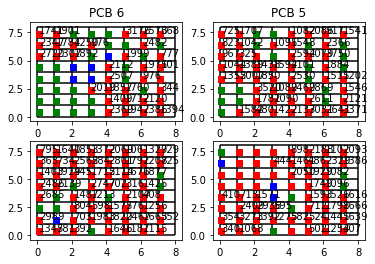